In [1]:
from utils import *
from plot_utils import *

google_lat, google_lon = 46.500458, 8.052669


year = 2020
month = 1
day = 1

interval = 30
n_intervals = 0

start_date = datetime.date(year = year, month = month, day = day)
start_date = datetime.datetime.now().date()

td = datetime.timedelta(days = interval)
final_date = start_date + n_intervals * td

metadata_links = {'2m' : '/Users/george-birchenough/Downloads/ch.swisstopo.swissalti3d-fGQ3d2A6.csv' , \
                  '0.5m' : 'https://ogd.swisstopo.admin.ch/resources/ch.swisstopo.swissalti3d-3TuKAiHo.csv' }

transformer = Transformer.from_crs( 'epsg:4326', 'epsg:2056' )
observer_lon, observer_lat = transformer.transform( google_lat, google_lon)

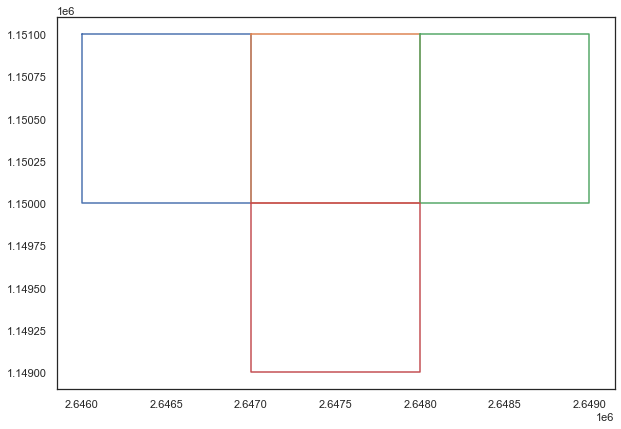

In [2]:
filename = metadata_links['2m']
grid_size = 2
radius = 1
tile_meta_df = get_tile_metadata(filename)
target_tiles = get_targets(observer_lat, observer_lon, tile_meta_df, radius)
plot_tile_corners(target_tiles)

Opening tile number  0  of  4
Opening tile number  1  of  4
Opening tile number  2  of  4
Opening tile number  3  of  4
Done.
Merging ... 
Done.


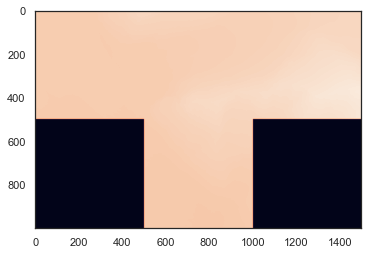

<AxesSubplot:>

In [3]:
array, blank_array = get_tiles(target_tiles)
show(array)

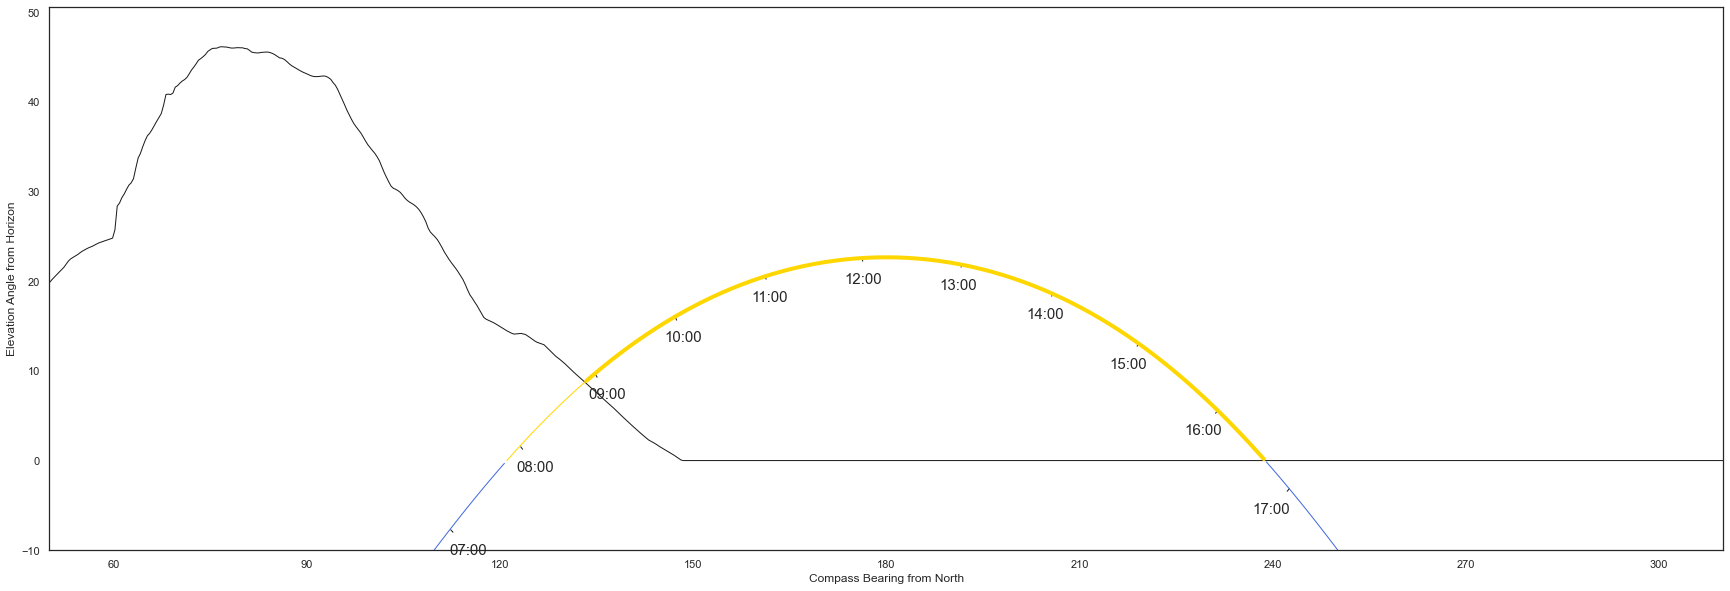

In [4]:
observer_pixel, observer_height = get_observer_position(array, blank_array, observer_lat, observer_lon )
peaks_df = get_peaks( array, observer_pixel, observer_height, grid_size)

fig, ax = plt.subplots(figsize=(30, 10))
sns.lineplot(x = peaks_df.bearing_deg, y = peaks_df.peak_angle  , color="k", linewidth=1)

hour = np.arange(4, 22)
tdf_ = pd.DataFrame(columns = ['date', 'time', 'azimuth', 'elevation'])
tdf = tdf_.copy()
date = start_date
amdf = pd.DataFrame()
while date <= final_date:
    sun_df = get_sun_path(google_lat, google_lon, observer_height, date)
    mdf = get_mtn_sun_times(get_suntimes (peaks_df, sun_df))
    mdf['date'] = date
    # time_df.index = ['azimuth', 'elevation']
    for i in hour:
        ind = mdf.time_since_midnight.sub( i*60 ).abs().idxmin()
        tdf_.loc[i, 'azimuth'] = mdf.loc[ind, 'azimuth']
        tdf_.loc[i, 'elevation'] = mdf.loc[ind, 'elevation'] 
    tdf_['grad'] = np.gradient(tdf_.elevation, tdf_.azimuth)
    tdf_['date'] = date
    tdf_['time'] = hour
    tdf_['midday_elev'] = max(mdf.elevation)
    tdf = pd.concat([tdf, tdf_])
    tdf.reset_index(drop = True, inplace = True)
    amdf = pd.concat([amdf, mdf])
    date = date+td

    plot_sun_paths(mdf)

# for h in hour:
#     x = tdf.loc[ tdf.index == h, 'azimuth'].reset_index(drop = True)
#     y = tdf.loc[ tdf.index == h, 'elevation'].reset_index(drop = True)
#     sns.lineplot(x=x, y=y )

gdf = tdf.groupby('time')
for hour, df in gdf:
    df = df.sort_values('date').reset_index()
    # print(df.head)
    x = df.azimuth
    y = df.elevation
    m = df.grad
    verts = list( zip( list( np.ones(len(m))),  list(m) ) )    
    sns.lineplot(x=x, y=y, sort=False, color='k', linewidth=0.5)
    # plt.scatter(x=x,y=y,color='k' \
    # , marker = verts \
    # )
plot_timelines(tdf)

sns.set_theme(style="whitegrid", font_scale = 1)
ax.set_xticks( np.arange(0,360,30) ) 
ax.set_xlim(50, 310 )
ax.set_ylim(-10)
plt.xlabel( 'Compass Bearing from North')
plt.ylabel( 'Elevation Angle from Horizon')
plt.show()
fig.savefig('/Users/george-birchenough/Documents/Plots/vectorplot.eps', format='eps')

In [5]:
epoch_df = pd.DataFrame()
for date, gdf in amdf.groupby('date'):
    gdf.sort_values('time_since_midnight', inplace =True)
    epoch_df_ = pd.DataFrame(columns = ['date', 'epoch', 'start_time', 'end_time', 'daylight'])
    for i, epoch in enumerate(gdf.epoch.unique()):
        start = gdf.loc[ gdf.epoch == epoch , 'time_since_midnight' ].min()
        end = gdf.loc[ gdf.epoch == epoch , 'time_since_midnight' ].max()
        daylight = str( gdf.loc[ gdf.epoch == epoch , 'daylight' ].unique() )
        epoch_df_.loc[i, :] = [ date, epoch, start, end, daylight ]
    epoch_df = pd.concat([epoch_df, epoch_df_])

In [8]:
import plotly as py
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

app = dash.Dash('Dash Hello World')

text_style = dict(color='#444', fontFamily='sans-serif', fontWeight=300)
plotly_fig = py.tools.mpl_to_plotly(fig)

app.layout = html.Div([ 
        html.H2('My First Dash App', style=text_style),
        dcc.Graph(id='plot1', figure=plotly_fig),
    ])

@app.callback(Output('plot1', 'figure'), [Input('text1', 'value')] )
def text_callback( text_input ):
    return {'data': [dict(x=[1,2,3], y=[2,4,8], type=text_input)]}

app.server.run()

 * Serving Flask app 'Dash Hello World' (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


/Users/george-birchenough/opt/anaconda3/envs/solmap/lib/python3.7/site-packages/plotly/matplotlylib/mplexporter/exporter.py:289: MatplotlibDeprecationWarning:


The get_offset_position function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.

 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
127.0.0.1 - - [25/Nov/2021 17:49:18] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2021 17:49:18] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2021 17:49:18] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2021 17:49:18] "GET /_dash-component-suites/dash/dcc/async-graph.js HTTP/1.1" 200 -
127.0.0.1 - - [25/Nov/2021 17:49:18] "GET /_dash-component-suites/dash/dcc/async-plotlyjs.js HTTP/1.1" 200 -


In [7]:
plotly_fig